# Libraries

In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work
from itertools import cycle
import math
import collections

from importlib import reload  
from mAP_daniel import main2
main2 = reload(main2)

import urllib
from smb.SMBHandler import SMBHandler
from io import StringIO

In [2]:
folder_name = 'apizoom_SCLD_1500'
file_path = '../ApiZoom_SIMRDWN_dataIN/' + folder_name + '/'
file_path_out = '../ApiZoom_SIMRDWN_dataOUT/' + folder_name + '/'
file_path_JPEGimages = file_path + 'images/'
file_path_annotations = file_path + 'Annotations/'
file_path_annotated = file_path + 'Annotated_PNG/'
file_path_overlay = file_path_out + 'overlay_resized_jpg/'
file_path_marked = file_path_out + 'marked/'
file_path_annotations = file_path + 'Annotations/'
file_path_annotated = file_path + 'Annotated_PNG/'
output_labels = file_path + 'labels/'
output_labels_overlay_scaled = file_path_out + 'labels_overlay_scaled/'
output_labels_overlay_scaled_jpg = file_path_out + 'labels_overlay_scaled_jpg/'

In [3]:
folder_name_org = 'VOC2007_SCLD_org'
file_path_org = '../ApiZoom_SIMRDWN_dataIN/' + folder_name_org + '/'
file_path_JPEGimages_org = file_path_org + 'images/'
file_path_annotations_org = file_path_org + 'Annotations/'

file_path_overlay_resized_bb_jpg = file_path_out + 'overlay_resized_bb_jpg/'
file_path_overlay_bb_jpg = file_path_out + 'overlay_bb_jpg/'

In [4]:
test_folder_dict = {
                    # YOLT2
                    'yolt2_416':'test_yolt2_apizoom_416_2020_06_15_16-05-27',\
                    'yolt2_544':'test_yolt2_apizoom_544_2020_06_01_20-59-41',\
                    'yolt2_1500_custom':'test_yolt2_compare_1500_custom_cut_corr_2020_05_18_17-06-08',\
                    'yolt2_1500_EPFL':'test_yolt2_compare_1500_EPFL_cut_2020_05_21_12-47-35',\
                    'yolt2_416_scaled_bb':'test_yolt2_416_bb_2020_05_24_11-31-31',\
                    'yolt2_1500_custom_scaled_bb':'test_yolt2_1500_custom_cut_bb_2020_05_24_11-26-21',\
                    'yolt2_1500_EPFL_scaled_bb':'test_yolt2_1500_EPFL_cut_bb_2020_05_24_11-23-09',\
                    'yolt2_832_416': 'test_yolt2_apizoom_832_416_2020_06_03_18-34-56',\
                    'yolt2_832_832': 'test_yolt2_overlay_scaled_832_cut_images_2020_05_14_07-57-41',\
                     'yolt2_832': 'test_yolt2_apizoom_832_2020_06_03_18-30-16',\
                     'yolt2_832_416': 'test_yolt2_apizoom_832_416_2020_06_03_18-34-56',\
                     'yolt2_1248': 'test_yolt2_apizoom_1248_2020_06_10_19-12-10',\
                     'yolt2_416_f': 'test_yolt2_apizoom_416_f_2020_06_14_14-55-13',\
                     'yolt2_832_f': 'test_yolt2_apizoom_832_f_2020_06_14_15-39-35',\
                     'yolt2_1248_f': 'test_yolt2_apizoom_1248_f_2020_06_14_15-49-09',\
    
                    # YOLT3
                    'yolt3_416_scaled_bb':'test_yolt3_416_bb_2020_05_24_11-28-36',\
                    'yolt3_544':'test_yolt3_apizoom_544_2020_05_24_10-15-45',\
                    'yolt3_544_scaled_bb':'test_yolt2_416_bb_2020_05_24_11-31-31',\
                    'yolt3_416':'test_yolt3_apizoom_416_2020_06_15_15-25-41',\
                     'yolt3_832_png': 'test_yolt3_apizoom_832_2020_06_10_16-40-44',\
                     'yolt3_1088': 'test_yolt3_apizoom_1088_2020_06_08_05-59-50',\
                     'yolt3_832': 'test_yolt3_apizoom_832_2020_06_10_17-50-36',\
                     'yolt3_832_832': 'test_yolt3_apizoom_832_2020_06_15_15-20-45',\
                    'yolt3_1248': 'test_yolt3_apizoom_1248_2020_06_15_15-31-08',\
                     'yolt3_416_f': 'test_yolt3_apizoom_416_f_2020_06_14_14-58-25',\
                     'yolt3_832_f': 'test_yolt3_apizoom_832_f_2020_06_14_15-03-08',\
                     'yolt3_1248_f': 'test_yolt3_apizoom_1248_f_2020_06_14_15-04-57',\
    
                    # SSD
                    'ssd_544_f': 'test_ssd_apizoom_inception_v2_2020_05_30_11-40-53',\
                    'ssd_544': 'test_ssd_apizoom_inception_v2_2020_05_30_16-16-10',\
                    'ssd_544_db': 'test_ssd_apizoom_inception_v2_2020_05_30_20-21-58',\
                    'ssd_544_db2': 'test_ssd_apizoom_inception_v2_2020_06_01_20-31-05', \
                    'ssd_544_30': 'test_ssd_apizoom_inception_v2_2020_06_02_08-42-32', \
                    'ssd_1500_30': 'test_ssd_apizoom_inception_v2_2020_06_03_18-14-04',\
                     'ssd_900': 'test_ssd_apizoom_inception_v2_900_2020_06_12_06-06-25',\
                    'ssd_1248': 'test_ssd_apizoom_inception_v2_1248_2020_06_14_04-52-43',\
                    'ssd_832': 'test_ssd_apizoom_inception_v2_832_2020_06_14_12-51-40',\
                    'ssd_832_60': 'test_ssd_apizoom_inception_v2_832_2020_06_16_08-51-46',\
                    'ssd_416': 'test_ssd_apizoom_inception_v2_416_2020_06_14_15-53-36',\
                    'ssd_1248_f': 'test_ssd_apizoom_inception_v2_1248_2020_06_12_05-59-20',\
                    'ssd_832_f': 'test_ssd_apizoom_inception_v2_832_2020_06_12_06-02-31',\
                    'ssd_416_f': 'test_ssd_apizoom_inception_v2_416_f_2020_06_14_16-00-54',\
                    
                    # SSD mobilenet v1
                    'ssd_mobile_832': 'test_ssd_apizoom_mobilenet_v1_832_2020_06_18_05-52-53',\

                   }

In [5]:
test_folder_dict.keys()

dict_keys(['yolt2_416', 'yolt2_544', 'yolt2_1500_custom', 'yolt2_1500_EPFL', 'yolt2_416_scaled_bb', 'yolt2_1500_custom_scaled_bb', 'yolt2_1500_EPFL_scaled_bb', 'yolt2_832_416', 'yolt2_832_832', 'yolt2_832', 'yolt2_1248', 'yolt2_416_f', 'yolt2_832_f', 'yolt2_1248_f', 'yolt3_416_scaled_bb', 'yolt3_544', 'yolt3_544_scaled_bb', 'yolt3_416', 'yolt3_832_png', 'yolt3_1088', 'yolt3_832', 'yolt3_832_832', 'yolt3_1248', 'yolt3_416_f', 'yolt3_832_f', 'yolt3_1248_f', 'ssd_544_f', 'ssd_544', 'ssd_544_db', 'ssd_544_db2', 'ssd_544_30', 'ssd_1500_30', 'ssd_900', 'ssd_1248', 'ssd_832', 'ssd_832_60', 'ssd_416', 'ssd_1248_f', 'ssd_832_f', 'ssd_416_f', 'ssd_mobile_832'])

# Extract XML into a DF

In [6]:
def xml_to_df(path):
    xml_list = []
    counter = 0
    #for  in glob.glob(path + '/*.xml'):
    for xml_file in listdir(path):
        filename, file_extension = os.path.splitext(xml_file)
        #print(filename)
        #print(xml_file)
        counter += 1       

        if isfile(join(path, xml_file)) and file_extension == ".xml" and not filename.startswith("._"):
            tree = ET.parse(join(path, xml_file))
            #print(join(path, xml_file))
            root = tree.getroot()
            for member in root.findall('object'):
                value = (filename,
                         #int(root.find('size')[0].text),
                         #int(root.find('size')[1].text),


                         member[0].text,
                         int(member[2][0].text),
                         int(member[2][1].text),
                         int(member[2][2].text),
                         int(member[2][3].text),
                         #counter,
                         )
                xml_list.append(value)
                
    column_name = ['filename','class', 'x1', 'y1', 'x2', 'y2'] # 'width', 'height', 'counter'
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    print(counter)
    return xml_df

# transpose to YOLO

In [7]:
# The following code is the modified version of codes available here: 
# https://blog.goodaudience.com/part-1-preparing-data-before-training-yolo-v2-and-v3-deepfashion-dataset-3122cd7dd884

def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    #print(size)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_labels_quick(org_img, x1, y1, x2, y2, dict_wh):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = dict_wh[org_img]
    #size = get_img_shape(path)
    #print(size)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[0]
    dh = 1./size[1]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def get_img_shape(path):
    #path = file_path_JPEGimages + path
    img = cv2.imread(path)
    try:
        return img.shape
    except AttributeError:
        print('error! ', path)
        return (None, None, None)
    
# bbox_img['x'], bbox_img['y'], bbox_img['width'], bbox_img['height'] = zip(*bbox_img.progress_apply(lambda row: convert_labels(row['Path'], row['x1'], row['y1'], row['x2'], row['y2']), axis=1)) # Like python for one lone 
# code.df = bbox_img.merge(train_test_valid_anot).merge(categories_img)
# df.to_csv('data/Anno/annotation_w-o_atr.csv', index=False)



# Load Results

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [9]:
## resize images for uniform varroa size
def get_dict_wh(path):
    counter = 0
    dict_wh = {}

    for image in listdir(path):
        filename, file_extension = os.path.splitext(image)
        if isfile(join(path, image)) and file_extension == ".jpg" and not filename.startswith("._"):
            refFilename = path + image
            print(refFilename)
            imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
            size_org = get_img_shape(refFilename)
            org_w, org_h = size_org[1], size_org[0]

            dict_wh[image] = [org_w, org_h]
            counter += 1
            print(counter)
    return dict_wh

In [10]:
#dict_wh_org = get_dict_wh(file_path_JPEGimages_org)
dict_wh_resized = get_dict_wh(file_path_overlay)
dict_wh_bb = get_dict_wh(file_path_overlay_resized_bb_jpg)

../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_58e7c5e3579e52085efb48f4_overlay_resized.jpg
1
../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_599ad189579e52a0e6c05e58_overlay_resized.jpg
2
../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_58ea4f69579e520dd055b3db_overlay_resized.jpg
3
../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_598a0f0f579e528819ade1f0_overlay_resized.jpg
4
../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_599a9c30579e52a0e6c05e50_overlay_resized.jpg
5
../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_5984d804579e529fdea8af0f_overlay_resized.jpg
6
../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_599a8abb579e52a0e6c05e4c_overlay_resized.jpg
7
../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/overlay_resized_jpg/test_set_59b0160ea07d5630fdf12ae1_overlay_resized.jpg
8
../ApiZoom_SIMRDWN_dataOUT/apizo

In [11]:
dict_wh_bb

{'test_set_59496f73579e529fdea8af00_overlay_resized_bb.jpg': [4496, 3000],
 'test_set_599ad189579e52a0e6c05e58_overlay_resized_bb.jpg': [7958, 5312],
 'test_set_59989236a07d5632dfefa440_overlay_resized_bb.jpg': [2643, 1982],
 'test_set_59993d62a07d5632dfefa445_overlay_resized_bb.jpg': [2502, 1876],
 'test_set_599ad824579e52a0e6c05e5b_overlay_resized_bb.jpg': [10680, 6008],
 'test_set_599d4db0579e52a0e6c05e6a_overlay_resized_bb.jpg': [3956, 2967],
 'test_set_599a8abb579e52a0e6c05e4c_overlay_resized_bb.jpg': [3140, 2355],
 'test_set_5984dc46579e529fdea8af12_overlay_resized_bb.jpg': [2254, 1691],
 'test_set_59cb57f8a07d562888f854f5_overlay_resized_bb.jpg': [7897, 6696],
 'test_set_5991a401579e52a0e6c05e48_overlay_resized_bb.jpg': [4659, 3494],
 'test_set_5903312b579e52581ddedea8_overlay_resized_bb.jpg': [6766, 3806],
 'test_set_59b0160ea07d5630fdf12ae1_overlay_resized_bb.jpg': [7207, 4054],
 'test_set_599a9c30579e52a0e6c05e50_overlay_resized_bb.jpg': [4264, 3198],
 'test_set_59a57c0aa07d5

In [12]:
opener = urllib.request.build_opener(SMBHandler)
file_path_results = 'smb://Guest:@FIGHT2/results/' 
dict_pred_df = {}

for key, value in test_folder_dict.items():
    print(key)
    path_pred = file_path_results + value + '/test_predictions_refine_thresh=0.0.csv'
    #print(path_pred)
    fh = opener.open(path_pred)
    bytes_data = fh.read()
    s=str(bytes_data,'utf-8')
    data = StringIO(s) 
    fh.close()
    df_pred = pd.read_csv(data, index_col = 0)
    df_pred = df_pred.sort_values(by=['Image_Root'])
    if 'bb' in str(key):
        # change to yolo format
        df_pred['x'], df_pred['y'], df_pred['width'], df_pred['height'] = \
        zip(*df_pred.apply(lambda row: convert_labels_quick(row['Image_Root'], row['Xmin_Glob'], row['Ymin_Glob'], row['Xmax_Glob'], row['Ymax_Glob'], dict_wh_bb), axis = 1))
    else:
        # change to yolo format
        df_pred['x'], df_pred['y'], df_pred['width'], df_pred['height'] = \
        zip(*df_pred.apply(lambda row: convert_labels_quick(row['Image_Root'], row['Xmin_Glob'], row['Ymin_Glob'], row['Xmax_Glob'], row['Ymax_Glob'], dict_wh_resized), axis = 1))

    df_pred['class'] = 0
    df_pred.sort_values(by= ['Prob'])
    dict_pred_df[key] = df_pred


yolt2_416
yolt2_544
yolt2_1500_custom
yolt2_1500_EPFL
yolt2_416_scaled_bb
yolt2_1500_custom_scaled_bb
yolt2_1500_EPFL_scaled_bb
yolt2_832_416
yolt2_832_832
yolt2_832
yolt2_1248
yolt2_416_f
yolt2_832_f
yolt2_1248_f
yolt3_416_scaled_bb
yolt3_544
yolt3_544_scaled_bb
yolt3_416
yolt3_832_png
yolt3_1088
yolt3_832
yolt3_832_832
yolt3_1248
yolt3_416_f
yolt3_832_f
yolt3_1248_f
ssd_544_f
ssd_544
ssd_544_db
ssd_544_db2
ssd_544_30
ssd_1500_30
ssd_900
ssd_1248
ssd_832
ssd_832_60
ssd_416
ssd_1248_f
ssd_832_f
ssd_416_f
ssd_mobile_832


In [13]:
# seems to be wrong as other examples show 0.0.. numbers
# let us test
def from_yolo_to_cor(box, shape):
    img_h, img_w, _ = shape
    # x1, y1 = ((x + witdth)/2)*img_width, ((y + height)/2)*img_height
    # x2, y2 = ((x - witdth)/2)*img_width, ((y - height)/2)*img_height
    x1, y1 = int((box[0] + box[2]/2)*img_w), int((box[1] + box[3]/2)*img_h)
    x2, y2 = int((box[0] - box[2]/2)*img_w), int((box[1] - box[3]/2)*img_h)
    return x1, y1, x2, y2
    
def draw_boxes(img, box):
    #for box in boxes:
    x1, y1, x2, y2 = from_yolo_to_cor(box, img.shape)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 3)
    #plt.figure(figsize = (20,20))
    plt.imshow(img)

In [14]:
print('length df_pred: ', len(df_pred))

length df_pred:  35003


# Load Ground-truth

In [15]:
def yolo_to_df(path):
    txt_list = []
    counter = 0
    for txt_file in listdir(path):
        filename, file_extension = os.path.splitext(txt_file)
        #print(filename)
        #print(txt_file)
        counter += 1       

        if isfile(join(path, txt_file)) and file_extension == ".txt" and not filename.startswith("._"):
            with open(join(path, txt_file),'r') as f:
                for line in f:
                    member = line.split()
                    value = (filename,
                             float(member[0]),
                             float(member[1]),
                             float(member[2]),
                             float(member[3]),
                             float(member[4]))
                    txt_list.append(value)
    column_name = ['filename','class', 'x', 'y', 'width', 'height'] # 'width', 'height', 'counter'
    yolo_df = pd.DataFrame(txt_list, columns=column_name)
    print(counter)
    return yolo_df

In [16]:
df_gt = pd.read_csv(file_path_out + 'test_ground_truth_overlay_scaled.csv')

In [17]:
#df_gt['filename'] = df_gt['filename'] + '.jpg'
df_gt['filename'] = df_gt['org_img'] + '_overlay_resized.jpg'

In [18]:
df_gt

filename  name   x_via   y_via  \
0     test_set_58e7c5e3579e52085efb48f4_overlay_resi...  rect  1639.0   897.0   
1     test_set_58e7c5e3579e52085efb48f4_overlay_resi...  rect  1331.0  2146.0   
2     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  3253.0  1540.0   
3     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  1898.0  1359.0   
4     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  1563.0  1987.0   
...                                                 ...   ...     ...     ...   
2755  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1658.0  1797.0   
2756  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1622.0  1140.0   
2757  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  4368.0  1795.0   
2758  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1601.0   143.0   
2759  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1613.0   560.0   

      width_via  height_via  cx  cy   r                            org_img  \
0          38.0        37.0 NaN NaN NaN  test_set_58e7c5e3579e52085efb48f4   
1          37.0        37.0 NaN NaN NaN  test_set_58e7c5e3579e52085efb48f4   
2          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
3          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
4          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
...         ...         ...  ..  ..  ..                                ...   
2755       41.0        50.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2756       46.0        41.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2757       55.0        48.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2758       45.0        52.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2759       45.0        50.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   

        x1    x2    y1    y2  \
0     1490  1524   815   849   
1     1210  1243  1951  1984   
2     4484  4524  2123  2163   
3     2616  2656  1873  1913   
4     2155  2195  2739  2779   
...    ...   ...   ...   ...   
2755  1313  1345  1423  1463   
2756  1284  1321   903   935   
2757  3459  3502  1421  1459   
2758  1268  1303   113   154   
2759  1277  1313   443   483   

                                           path_img_org         x         y  \
0     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.312138  0.306333   
1     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.254039  0.724411   
2     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.597189  0.504473   
3     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.349509  0.445621   
4     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.288385  0.649482   
...                                                 ...       ...       ...   
2755  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.345016  0.499654   
2756  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.338136  0.318213   
2757  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.903557  0.498615   
2758  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.333723  0.046226   
2759  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.336189  0.160319   

         width    height  class  
0     0.007042  0.012518      0  
1     0.006835  0.012150      0  
2     0.005304  0.009416      0  
3     0.005304  0.009416      0  
4     0.005304  0.009416      0  
...        ...       ...    ...  
2755  0.008307  0.013850      0  
2756  0.009605  0.011080      0  
2757  0.011163  0.013158      0  
2758  0.009086  0.014197      0  
2759  0.009346  0.013850      0  

[2760 rows x 20 columns]

In [19]:
train_gt = df_gt[df_gt['filename'].str.contains('test|validation', regex=True)==False]
test_gt = df_gt[df_gt['filename'].str.contains('test', regex=True)==True]
val_gt = df_gt[df_gt['filename'].str.contains('validation', regex=True)==True]
print('train: ' + str(len(train_gt)) + ' val: ' + str(len(val_gt)) + ' test: ' + str(len(test_gt)))
print('total: ' + str(len(train_gt) + len(val_gt) + len(test_gt))) 

train: 0 val: 0 test: 2760
total: 2760


# Load Ground-truth bb

This test set was scaled according to bounding box sizes i.e. bounding box diagonal of 40

In [20]:
def yolo_to_df(path):
    txt_list = []
    counter = 0
    for txt_file in listdir(path):
        filename, file_extension = os.path.splitext(txt_file)
        #print(filename)
        #print(txt_file)
        counter += 1       

        if isfile(join(path, txt_file)) and file_extension == ".txt" and not filename.startswith("._"):
            with open(join(path, txt_file),'r') as f:
                for line in f:
                    member = line.split()
                    value = (filename,
                             float(member[0]),
                             float(member[1]),
                             float(member[2]),
                             float(member[3]),
                             float(member[4]))
                    txt_list.append(value)
    column_name = ['filename','class', 'x', 'y', 'width', 'height'] # 'width', 'height', 'counter'
    yolo_df = pd.DataFrame(txt_list, columns=column_name)
    print(counter)
    return yolo_df

In [21]:
df_gt_bb = pd.read_csv(file_path_out + 'test_ground_truth_overlay_scaled_bb.csv')

In [22]:
#df_gt['filename'] = df_gt['filename'] + '.jpg'
df_gt_bb['filename'] = df_gt_bb['org_img'] + '_overlay_resized_bb.jpg'

In [23]:
df_gt_bb

filename  name   x_via   y_via  \
0     test_set_58e7c5e3579e52085efb48f4_overlay_resi...  rect  1639.0   897.0   
1     test_set_58e7c5e3579e52085efb48f4_overlay_resi...  rect  1331.0  2146.0   
2     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  3253.0  1540.0   
3     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  1898.0  1359.0   
4     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  1563.0  1987.0   
...                                                 ...   ...     ...     ...   
2755  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1658.0  1797.0   
2756  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1622.0  1140.0   
2757  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  4368.0  1795.0   
2758  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1601.0   143.0   
2759  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1613.0   560.0   

      width_via  height_via  cx  cy   r                            org_img  \
0          38.0        37.0 NaN NaN NaN  test_set_58e7c5e3579e52085efb48f4   
1          37.0        37.0 NaN NaN NaN  test_set_58e7c5e3579e52085efb48f4   
2          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
3          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
4          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
...         ...         ...  ..  ..  ..                                ...   
2755       41.0        50.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2756       46.0        41.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2757       55.0        48.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2758       45.0        52.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2759       45.0        50.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   

        x1    x2    y1    y2  bb_width  bb_height    bb_diag     scale  \
0     1245  1273   681   709        28         28  39.597980  0.754180   
1     1011  1039  1629  1658        28         29  40.311289  0.764440   
2     3173  3201  1502  1530        28         28  39.597980  0.975320   
3     1851  1879  1325  1354        28         29  40.311289  0.975320   
4     1524  1553  1938  1966        29         28  40.311289  0.975320   
...    ...   ...   ...   ...       ...        ...        ...       ...   
2755   901   923   976  1004        22         28  35.608988  0.618614   
2756   881   906   619   642        25         23  33.970576  0.649142   
2757  2373  2403   975  1001        30         26  39.698866  0.547945   
2758   870   894    78   106        24         28  36.878178  0.581668   
2759   876   901   304   331        25         27  36.796739  0.594635   

                                           path_img_org         x         y  \
0     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.312175  0.306302   
1     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.254153  0.724328   
2     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.597152  0.504660   
3     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.349447  0.445905   
4     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.288271  0.649800   
...                                                 ...       ...       ...   
2755  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.345062  0.499495   
2756  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.338063  0.318113   
2757  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.903519  0.498486   
2758  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.333712  0.046418   
2759  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.336171  0.160192   

         width    height  class  
0     0.006943  0.012340      0  
1     0.006943  0.012781      0  
2     0.005246  0.009321      0  
3     0.005246  0.009654      0  
4     0.005434  0.009321      0  
...        ...       ...    ...  
2755  0.008324  0.014127      0  
2756  0.009459  0.011604   

In [24]:
train_gt_bb = df_gt_bb[df_gt_bb['filename'].str.contains('test|validation', regex=True)==False]
test_gt_bb = df_gt_bb[df_gt_bb['filename'].str.contains('test', regex=True)==True]
val_gt_bb = df_gt_bb[df_gt_bb['filename'].str.contains('validation', regex=True)==True]
print('train: ' + str(len(train_gt_bb)) + ' val: ' + str(len(val_gt_bb)) + ' test: ' + str(len(test_gt_bb)))
print('total: ' + str(len(train_gt_bb) + len(val_gt_bb) + len(test_gt_bb))) 

train: 0 val: 0 test: 2760
total: 2760


# Load EPFL ground truth

In [25]:
df_EPFL = xml_to_df(file_path_annotations_org)
#df_SCLD = convert_labels(file_path_annotations_SCLD)

len(df_EPFL['filename'].unique())

df_EPFL

290


filename   class    x1    y1    x2  \
0        bugnon_5c2a527ba07d5605c141bf39_32px_0  Varroa  4740  4048  4761   
1        bugnon_5c2a527ba07d5605c141bf39_32px_0  Varroa  5552   824  5572   
2        bugnon_5c2a527ba07d5605c141bf39_32px_0  Varroa  4708  2544  4728   
3        bugnon_5c2a527ba07d5605c141bf39_32px_0  Varroa  4243  3407  4263   
4        bugnon_5c2a527ba07d5605c141bf39_32px_0  Varroa  4596  4252  4615   
...                                         ...     ...   ...   ...   ...   
27492  test_set_59b0160ea07d5630fdf12ae1_32px_0  Varroa  2338   714  2356   
27493  test_set_59b0160ea07d5630fdf12ae1_32px_0  Varroa  3421   860  3439   
27494  test_set_59b0160ea07d5630fdf12ae1_32px_0  Varroa  3560    60  3578   
27495  test_set_59b0160ea07d5630fdf12ae1_32px_0  Varroa  2012   596  2028   
27496  test_set_59b0160ea07d5630fdf12ae1_32px_0  Varroa  2943  1187  2960   

         y2  
0      4069  
1       846  
2      2565  
3      3427  
4      4272  
...     ...  
27492   732  
27493   880  
27494    78  
27495   614  
27496  1204  

[27497 rows x 6 columns]

In [26]:
df_EPFL['filename'] = df_EPFL['filename'] + '.jpg'

In [27]:
#df_EPFL['x'], df_EPFL['y'], df_EPFL['width'], df_EPFL['height'] = \
#zip(*df_EPFL.apply(lambda row: convert_labels_quick(row['filename'], row['x1'], row['y1'], row['x2'], row['y2'], dict_wh_org), axis = 1))

# Evaluate with Code from mAP package

https://github.com/Cartucho/mAP

In [28]:
from mAP_daniel import main2, apizoom_eval
main2 = reload(main2)
apizoom = reload(apizoom_eval)

In [29]:
model = 'yolt2_832'

In [30]:
df_gt0, df_pred0, TP, FP, FN, ap, mrec, mprec, rec, prec = main2.get_results(dict_pred_df[model], test_gt, 0.5, 0)
#df_gt5, df_pred5 = main2.get_results(df_pred, test_gt, 0.5, 0.25)

minimal overlap: 0.5
threshhold: 0
nd:  3386
fp -1:  1138
tp -1:  2248
73.26% = 0 AP 
mAP = 73.26%

# Number of ground-truth objects per class
0: 2760

TP: 2248, FP: 1138
FN: 512

 Precision: 0.6639102185469581
 Recall :0.8144927536231884
 F1-score: 0.7315327041978522

3388
-------------------------------------------------------


In [31]:
df_gt0

filename  name   x_via   y_via  \
0     test_set_58e7c5e3579e52085efb48f4_overlay_resi...  rect  1639.0   897.0   
1     test_set_58e7c5e3579e52085efb48f4_overlay_resi...  rect  1331.0  2146.0   
2     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  3253.0  1540.0   
3     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  1898.0  1359.0   
4     test_set_58ea4f69579e520dd055b3db_overlay_resi...  rect  1563.0  1987.0   
...                                                 ...   ...     ...     ...   
2755  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1658.0  1797.0   
2756  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1622.0  1140.0   
2757  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  4368.0  1795.0   
2758  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1601.0   143.0   
2759  test_set_59989236a07d5632dfefa440_overlay_resi...  rect  1613.0   560.0   

      width_via  height_via  cx  cy   r                            org_img  \
0          38.0        37.0 NaN NaN NaN  test_set_58e7c5e3579e52085efb48f4   
1          37.0        37.0 NaN NaN NaN  test_set_58e7c5e3579e52085efb48f4   
2          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
3          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
4          29.0        29.0 NaN NaN NaN  test_set_58ea4f69579e520dd055b3db   
...         ...         ...  ..  ..  ..                                ...   
2755       41.0        50.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2756       46.0        41.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2757       55.0        48.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2758       45.0        52.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   
2759       45.0        50.0 NaN NaN NaN  test_set_59989236a07d5632dfefa440   

        x1    x2    y1    y2  \
0     1490  1524   815   849   
1     1210  1243  1951  1984   
2     4484  4524  2123  2163   
3     2616  2656  1873  1913   
4     2155  2195  2739  2779   
...    ...   ...   ...   ...   
2755  1313  1345  1423  1463   
2756  1284  1321   903   935   
2757  3459  3502  1421  1459   
2758  1268  1303   113   154   
2759  1277  1313   443   483   

                                           path_img_org         x         y  \
0     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.312138  0.306333   
1     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.254039  0.724411   
2     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.597189  0.504473   
3     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.349509  0.445621   
4     ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.288385  0.649482   
...                                                 ...       ...       ...   
2755  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.345016  0.499654   
2756  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.338136  0.318213   
2757  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.903557  0.498615   
2758  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.333723  0.046226   
2759  ../ApiZoom_SIMRDWN_dataOUT/apizoom_SCLD_1500/o...  0.336189  0.160319   

         width    height  class   overlap used pred_index  
0     0.007042  0.012518      0   0.98726    1       2600  
1     0.006835  0.012150      0  0.987961    1       2604  
2     0.005304  0.009416      0  0.639043    1        369  
3     0.005304  0.009416      0  0.962183    1        325  
4     0.005304  0.009416      0  0.986035    1        310  
...        ...       ...    ...       ...  ...        ...  
2755  0.008307  0.013850      0  0.988236    1       2529  
2756  0.009605  0.011080      0  0.992063    1       2515  
2757  0.011163  0.013158      0  0.975621    1       2434  
2758  0.009086  0.014197      0  0.995811    1       2533  
2759  0.009346  0.013850      0  0.994844    1       2536  

[2760 rows x 23 columns]

In [32]:
len(df_pred0)

3386

In [33]:
len(prec)

3386

In [34]:
rec[-1]

0.8144927536231884

In [35]:
prec[-1]

0.6639102185469581

In [36]:
len(df_gt0['filename'].unique())

21

/Users/fight/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/_ApiZoom_SIMRDWN/ApiZoom_SIMRDWN_notebooks/venv_simrdwn/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


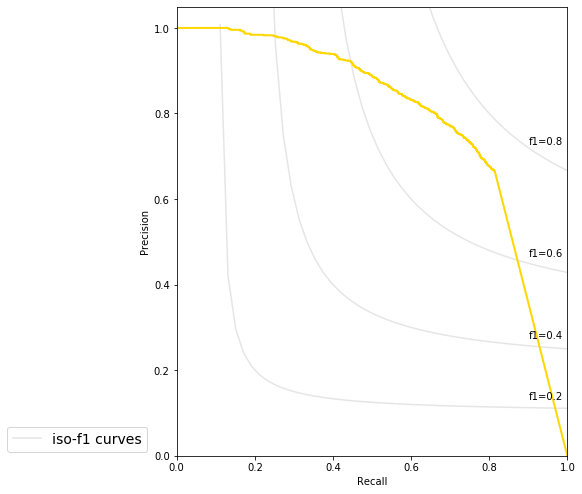

In [37]:
# setup plot details
colors = cycle([ 'teal', 'gold', 'midnightblue', 'darkorange'])
#'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

l, = plt.plot(mrec, mprec, color='gold', lw=2)
lines.append(l)

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#  plt.title('Precision-Recall curve to multi-models')
plt.legend(lines, labels, loc='top left', prop=dict(size=14), borderaxespad = 30)


plt.show()

In [38]:
df_pred0['match'] = df_pred0['gt_index'].apply(lambda x: 0 if x == None else 1)
df_all = pd.merge(test_gt, df_pred0, left_index = True, right_on='gt_index', how = 'outer')
df_all.fillna(0, inplace = True) 
df_all['pred'] = df_all['Prob'].apply(lambda x: 1 if x > 0 else 0)
y_score = df_all['Prob']
y_test = df_all['match']
y_pred = df_all['pred']

In [39]:
y_score

2600.0    0.206131
2604.0    0.645043
369.0     0.116117
325.0     0.332261
310.0     0.474391
            ...   
4798.0    0.025103
1456.0    0.025091
5759.0    0.025078
4572.0    0.025069
5073.0    0.025020
Name: Prob, Length: 3898, dtype: float64

In [40]:
df_pred0

Loc_Tmp      Prob        Xmin  \
3941  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.720742  520.498230   
2690  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.663445  168.299026   
99    /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.662734   88.301483   
854   /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.660213  616.625732   
1877  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.659997  379.658844   
...                                                 ...       ...         ...   
4798  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.025103    1.182363   
1456  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.025091  218.530365   
5759  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.025078  351.725891   
4572  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.025069  255.605621   
5073  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.025020  100.196106   

            Ymin        Xmax        Ymax Category  \
3941  765.308533  551.872620  799.372498   varroa   
2690  610.308960  195.985397  642.313599   varroa   
99    322.766663  124.889160  356.352356   varroa   
854    62.930458  651.062866   95.494423   varroa   
1877  444.151367  406.900238  471.314331   varroa   
...          ...         ...         ...      ...   
4798  364.087097   12.941902  393.169006   varroa   
1456  656.010742  240.653229  679.075439   varroa   
5759  393.351105  385.426575  429.298920   varroa   
4572   10.804510  288.398041   32.077705   varroa   
5073  563.491333  135.886475  601.895874   varroa   

                                             Image_Root  \
3941  test_set_59496f73579e529fdea8af00_overlay_resi...   
2690  test_set_59496f73579e529fdea8af00_overlay_resi...   
99    test_set_5991a401579e52a0e6c05e48_overlay_resi...   
854   test_set_599d4db0579e52a0e6c05e6a_overlay_resi...   
1877  test_set_59450ede579e529fdea8aefe_overlay_resi...   
...                                                 ...   
4798  test_set_599a9c30579e52a0e6c05e50_overlay_resi...   
1456  test_set_59450ede579e529fdea8aefe_overlay_resi...   
5759  test_set_599ab9d9579e52a0e6c05e56_overlay_resi...   
4572  test_set_599a9c30579e52a0e6c05e50_overlay_resi...   
5073  test_set_598a0f0f579e528819ade1f0_overlay_resi...   

                               Slice_XY   Upper    Left  Height  Width  Pad  \
3941  3302_3192_832_832_0_6195_4134.png  3302.0  3192.0   832.0  832.0  0.0   
2690  1596_3192_832_832_0_6195_4134.png  1596.0  3192.0   832.0  832.0  0.0   
99    1596_3990_832_832_0_5400_4050.png  1596.0  3990.0   832.0  832.0  0.0   
854   2394_1596_832_832_0_4900_3675.png  2394.0  1596.0   832.0  832.0  0.0   
1877  1596_5586_832_832_0_9807_6545.png  1596.0  5586.0   832.0  832.0  0.0   
...                                 ...     ...     ...     ...    ...  ...   
4798   798_2394_832_832_0_5008_3756.png   798.0  2394.0   832.0  832.0  0.0   
1456     0_3990_832_832_0_9807_6545.png     0.0  3990.0   832.0  832.0  0.0   
5759    798_798_832_832_0_4828_3621.png   798.0   798.0   832.0  832.0  0.0   
4572  2924_2394_832_832_0_5008_3756.png  2924.0  2394.0   832.0  832.0  0.0   
5073  3192_2394_832_832_0_6205_4656.png  3192.0  2394.0   832.0  832.0  0.0   

      Im_Width  Im_Height                                         Image_Path  \
3941    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
2690    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
99      5400.0     4050.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
854     4900.0     3675.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
1877    9807.0     6545.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
...        ...        ...                                                ...   
4798    5008.0     3756.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
1456    9807.0     6545.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
5759    4828.0     3621.0  /simrdwn/data/test_images/overlay

In [41]:
def make_dict(filename, x, y, width, height, dictionary):
    if filename not in dictionary:
        dictionary[filename] = [[x, y, width, height]]
    else:
        dictionary[filename].append([x, y, width, height])

In [42]:
filename = 'test_set_59496f73579e529fdea8af00_overlay_resized.jpg'

In [43]:
dict_pred_df[model][dict_pred_df[model]['Image_Root'] == filename].sort_values(by=['Left'], ascending=False)

Loc_Tmp      Prob        Xmin  \
2656  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.409319   53.609653   
3554  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.079697  247.402878   
3086  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.053089  565.346619   
3957  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.028077   12.702516   
3960  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.057665  195.464508   
...                                                 ...       ...         ...   
3954  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.041169  172.327591   
3953  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.225265  162.571243   
3955  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.028858  380.102509   
2714  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.164675  254.836288   
3229  /simrdwn/results/test_yolt2_apizoom_832_2020_0...  0.077841  694.799072   

            Ymin        Xmax        Ymax Category  \
2656  440.345581   86.462830  477.023682   varroa   
3554  498.800079  275.157166  533.896301   varroa   
3086  315.119263  593.323059  352.816345   varroa   
3957  329.661499   36.557121  361.804504   varroa   
3960  398.766235  219.885956  427.504089   varroa   
...          ...         ...         ...      ...   
3954  362.312317  192.415482  386.765198   varroa   
3953  258.729523  189.835098  289.766754   varroa   
3955  411.249207  408.084991  442.492981   varroa   
2714  176.622223  283.529633  213.114349   varroa   
3229  500.969238  718.632812  528.445923   varroa   

                                             Image_Root  \
2656  test_set_59496f73579e529fdea8af00_overlay_resi...   
3554  test_set_59496f73579e529fdea8af00_overlay_resi...   
3086  test_set_59496f73579e529fdea8af00_overlay_resi...   
3957  test_set_59496f73579e529fdea8af00_overlay_resi...   
3960  test_set_59496f73579e529fdea8af00_overlay_resi...   
...                                                 ...   
3954  test_set_59496f73579e529fdea8af00_overlay_resi...   
3953  test_set_59496f73579e529fdea8af00_overlay_resi...   
3955  test_set_59496f73579e529fdea8af00_overlay_resi...   
2714  test_set_59496f73579e529fdea8af00_overlay_resi...   
3229  test_set_59496f73579e529fdea8af00_overlay_resi...   

                               Slice_XY   Upper    Left  Height  Width  Pad  \
2656     0_5363_832_832_0_6195_4134.png     0.0  5363.0   832.0  832.0  0.0   
3554  2394_5363_832_832_0_6195_4134.png  2394.0  5363.0   832.0  832.0  0.0   
3086  3302_5363_832_832_0_6195_4134.png  3302.0  5363.0   832.0  832.0  0.0   
3957  3192_5363_832_832_0_6195_4134.png  3192.0  5363.0   832.0  832.0  0.0   
3960  3192_5363_832_832_0_6195_4134.png  3192.0  5363.0   832.0  832.0  0.0   
...                                 ...     ...     ...     ...    ...  ...   
3954        0_0_832_832_0_6195_4134.png     0.0     0.0   832.0  832.0  0.0   
3953        0_0_832_832_0_6195_4134.png     0.0     0.0   832.0  832.0  0.0   
3955        0_0_832_832_0_6195_4134.png     0.0     0.0   832.0  832.0  0.0   
2714     2394_0_832_832_0_6195_4134.png  2394.0     0.0   832.0  832.0  0.0   
3229     3192_0_832_832_0_6195_4134.png  3192.0     0.0   832.0  832.0  0.0   

      Im_Width  Im_Height                                         Image_Path  \
2656    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
3554    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
3086    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
3957    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
3960    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
...        ...        ...                                                ...   
3954    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
3953    6195.0     4134.0  /simrdwn/data/test_images/overlay_resized_jpg/...   
3955    6195.0     4134.0  /simrdwn/data/test_images/overlay

In [44]:
refFilename = file_path_overlay + filename
img_cv2 = cv2.imread(refFilename, 1)
print ("img_cv2.shape:", img_cv2.shape)
image = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
im_h, im_w = image.shape[:2]
print("image.shape:", image.shape)
print("image.shape:", image.shape[:2])
print('im_h, im_w: ', (im_h, im_w))

img_cv2.shape: (4134, 6195, 3)
image.shape: (4134, 6195, 3)
image.shape: (4134, 6195)
im_h, im_w:  (4134, 6195)


In [46]:
dict_gt = {}
df_gt0.apply(lambda x: make_dict(x.filename, x.x, x.y, x.width, x.height, dict_gt), axis = 1)
dict_pred = {}
df_pred0.apply(lambda x: make_dict(x.Image_Root, x.x, x.y, x.width, x.height, dict_pred), axis = 1)
dict_cut = {}
dict_pred_df[model].apply(lambda x: make_dict(x.Image_Root, int(x.Left), int(x.Upper), int(x.Left + x.Width), int(x.Upper + x.Height), dict_cut), axis = 1)
#dict_pred
#dict_gt

2600    None
2616    None
2614    None
2613    None
2610    None
        ... 
1259    None
1260    None
1262    None
1316    None
1317    None
Length: 3386, dtype: object

# Visualise

/Users/fight/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/_ApiZoom_SIMRDWN/ApiZoom_SIMRDWN_notebooks/venv_simrdwn/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/fight/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/_ApiZoom_SIMRDWN/ApiZoom_SIMRDWN_notebooks/venv_simrdwn/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

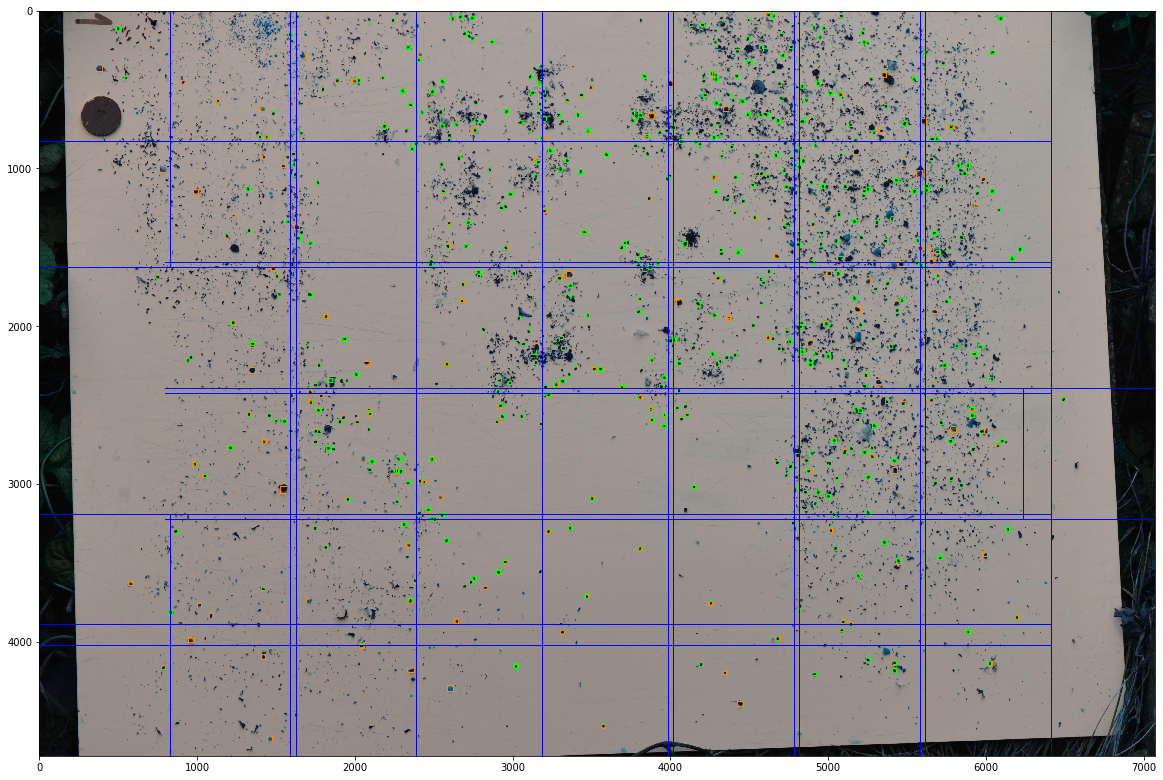

In [48]:
org_img = 'test_set_599ad189579e52a0e6c05e58'
filename = org_img + '_overlay_resized.jpg'
refFilename = file_path_overlay + filename
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
for box in dict_pred[filename]:
    x1, y1, x2, y2 = from_yolo_to_cor(box, imReference.shape)
    cv2.rectangle(imReference, (x1, y1), (x2, y2), (255,140,0), 3)
    plt.figure(figsize = (20,20))
for box in dict_gt[filename]:
    x1, y1, x2, y2 = from_yolo_to_cor(box, imReference.shape)
    cv2.rectangle(imReference, (x1, y1), (x2, y2), (0,255,0), 3)
    plt.figure(figsize = (20,20))
for box in dict_cut[filename]:
    x1, y1, x2, y2 = box
    cv2.rectangle(imReference, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(imReference)
#refFilename_marked = file_path_marked + org_img + "_yolt2_832.jpg"
#cv2.imwrite(refFilename_marked, imReference)


/Users/fight/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/_ApiZoom_SIMRDWN/ApiZoom_SIMRDWN_notebooks/venv_simrdwn/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/fight/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/_ApiZoom_SIMRDWN/ApiZoom_SIMRDWN_notebooks/venv_simrdwn/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


True

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

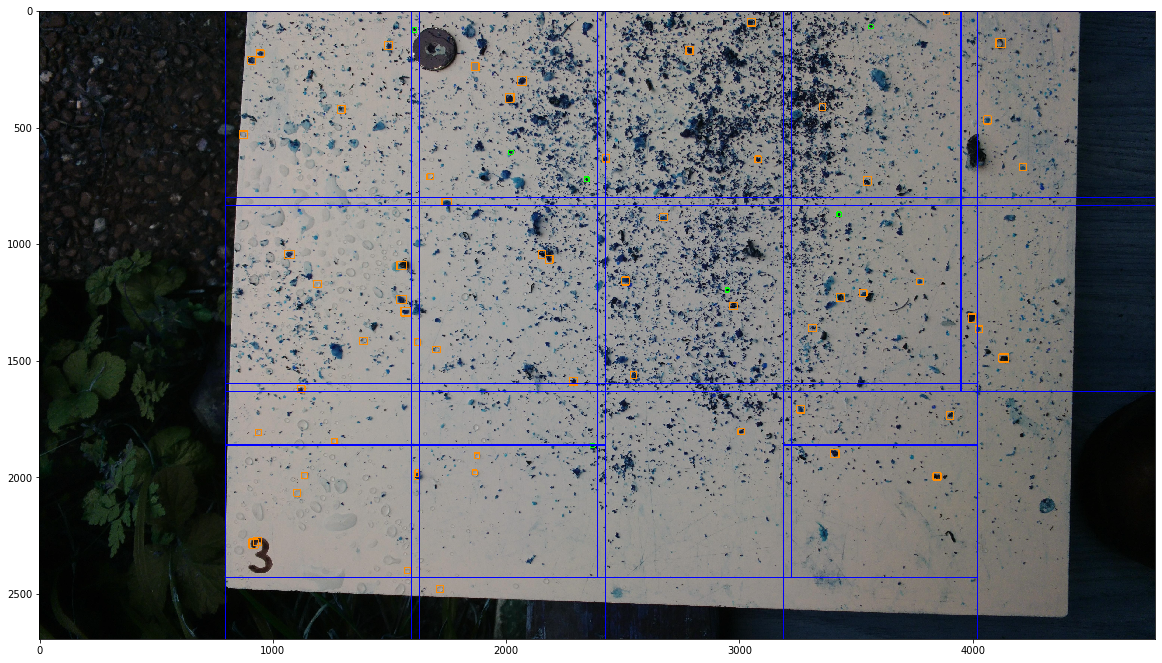

In [49]:
org_img = 'test_set_59b0160ea07d5630fdf12ae1'
filename = org_img + '_overlay_resized.jpg'
refFilename = file_path_overlay + filename
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
for box in dict_pred[filename]:
    x1, y1, x2, y2 = from_yolo_to_cor(box, imReference.shape)
    cv2.rectangle(imReference, (x1, y1), (x2, y2), (255,140,0), 3)
    plt.figure(figsize = (20,20))
for box in dict_gt[filename]:
    x1, y1, x2, y2 = from_yolo_to_cor(box, imReference.shape)
    cv2.rectangle(imReference, (x1, y1), (x2, y2), (0,255,0), 3)
    plt.figure(figsize = (20,20))
for box in dict_cut[filename]:
    x1, y1, x2, y2 = box
    cv2.rectangle(imReference, (x1, y1), (x2, y2), (0, 0, 255), 3)
    #cv2.putText(imReference, str(row.cut_img), (row.x1_bayes_offset + 40, row.y1_bayes_offset + 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

plt.imshow(imReference)
refFilename_marked = file_path_marked + org_img + "_yolt2_832.jpg"
cv2.imwrite(refFilename_marked, imReference)

# Multi-class Precision Recall curve

In [84]:
check_list = [
                    # YOLT2
                    'yolt2_416',\
                    'yolt2_544',\
                    'yolt2_1500_custom',\
                    'yolt2_1500_EPFL',\
                    'yolt2_416_scaled_bb',\
                    'yolt2_1500_custom_scaled_bb',\
                    'yolt2_1500_EPFL_scaled_bb',\
                    'yolt2_832_416',\
                    'yolt2_832_832',\
                     'yolt2_832',\
                     'yolt2_832_416',\
                     'yolt2_1248',\
                     'yolt2_416_f',\
                     'yolt2_832_f',\
                     'yolt2_1248_f',\
    
                    # YOLT3
                    'yolt3_416_scaled_bb',\
                    'yolt3_544',\
                    'yolt3_544_scaled_bb',\
                    'yolt3_416',\
                     'yolt3_832_png',\
                     'yolt3_1088',\
                     'yolt3_832',\
                     'yolt3_416_f',\
                     'yolt3_832_f',\
                     'yolt3_1248_f',\
                    'yolt3_1248',\
    
                    # SSD
                    'ssd_544_f',\
                    'ssd_544',\
                    'ssd_544_db',\
                    'ssd_544_db2',\
                    'ssd_544_30',\
                    'ssd_1500_30',\
                     'ssd_900',\
                    'ssd_1248',\
                    'ssd_832',\
                    'ssd_416',\
                    'ssd_1248_f',\
                    'ssd_832_f',\
                    'ssd_416_f',\
                    'ssd_832_60',\
    
                    # SSD mobilenet v1
                    'ssd_mobile_832',\
                ]

In [85]:
precision = dict()
recall = dict()
ap_dict = dict()
dict_all = dict()
df_results = pd.DataFrame(columns=['TP', 'FP', 'FN', 'AP_IoU=.50'])

In [86]:
for key, value in dict_pred_df.items():  
    if key in check_list:
    # for precision recall curve we need all values without a threshhold
        print('### ' + key + ' ###')
        if 'bb' in str(key):
            print('evaluated with: test_gt_bb')
            df_gt0, df_pred0, TP, FP, FN, ap, mrec, mprec, rec, prec = main2.get_results(value, test_gt_bb, 0.5, 0)
            df_pred0['match'] = df_pred0['gt_index'].apply(lambda x: 0 if x == None else 1)
            df_all = pd.merge(test_gt_bb, df_pred0, left_index = True, right_on='gt_index', how = 'outer')
            df_all = df_all.fillna(0, inplace = True) 
            #print('length df_pred0: ', len(df_pred0))
            #print('length df_all: ', len(df_all))
            dict_all[key] = df_all
            precision[key], recall[key] = mprec, mrec
            ap_dict[key] = ap
            df_results = df_results.append({'ID': key, 'TP': TP, 'FP' : FP, 'FN': FN, 'AP_IoU=.50': ap}, ignore_index=True)
            
        else:
            print('evaluated with: test_gt')
            df_gt0, df_pred0, TP, FP, FN, ap, mrec, mprec, rec, prec = main2.get_results(value, test_gt, 0.5, 0)
            df_pred0['match'] = df_pred0['gt_index'].apply(lambda x: 0 if x == None else 1)
            df_all = pd.merge(test_gt, df_pred0, left_index = True, right_on='gt_index', how = 'outer')
            df_all.fillna(0, inplace = True) 
            #print('length df_pred0: ', len(df_pred0))
            #print('length df_all: ', len(df_all))
            dict_all[key] = df_all
            precision[key], recall[key] = mprec, mrec
            ap_dict[key] = ap
            df_results = df_results.append({'ID': key,'TP': TP, 'FP' : FP, 'FN': FN, 'AP_IoU=.50': ap}, ignore_index=True)
            

### yolt2_416 ###
evaluated with: test_gt
minimal overlap: 0.5
threshhold: 0
nd:  9146
fp -1:  6525
tp -1:  2621
63.26% = 0 AP 
mAP = 63.26%

# Number of ground-truth objects per class
0: 2760

TP: 2621, FP: 6525
FN: 139

 Precision: 0.2865733654056418
 Recall :0.9496376811594203
 F1-score: 0.4402822106500924

9148
-------------------------------------------------------
### yolt2_544 ###
evaluated with: test_gt
minimal overlap: 0.5
threshhold: 0
nd:  6860
fp -1:  4273
tp -1:  2587
68.20% = 0 AP 
mAP = 68.20%

# Number of ground-truth objects per class
0: 2760

TP: 2587, FP: 4273
FN: 173

 Precision: 0.3771137026239067
 Recall :0.9373188405797102
 F1-score: 0.5378378378378378

6862
-------------------------------------------------------
### yolt2_1500_custom ###
evaluated with: test_gt
minimal overlap: 0.5
threshhold: 0
nd:  5783
fp -1:  3457
tp -1:  2326
66.87% = 0 AP 
mAP = 66.87%

# Number of ground-truth objects per class
0: 2760

TP: 2326, FP: 3457
FN: 434

 Precision: 0.4022133840

nd:  4294
fp -1:  2212
tp -1:  2082
56.09% = 0 AP 
mAP = 56.09%

# Number of ground-truth objects per class
0: 2760

TP: 2082, FP: 2212
FN: 678

 Precision: 0.4848625989753144
 Recall :0.7543478260869565
 F1-score: 0.5903033739722143

4296
-------------------------------------------------------
### yolt3_832_f ###
evaluated with: test_gt
minimal overlap: 0.5
threshhold: 0
nd:  2189
fp -1:  646
tp -1:  1543
46.98% = 0 AP 
mAP = 46.98%

# Number of ground-truth objects per class
0: 2760

TP: 1543, FP: 646
FN: 1217

 Precision: 0.7048880767473732
 Recall :0.5590579710144927
 F1-score: 0.623560315215195

2191
-------------------------------------------------------
### yolt3_1248_f ###
evaluated with: test_gt
minimal overlap: 0.5
threshhold: 0
nd:  2400
fp -1:  879
tp -1:  1521
44.71% = 0 AP 
mAP = 44.71%

# Number of ground-truth objects per class
0: 2760

TP: 1521, FP: 879
FN: 1239

 Precision: 0.63375
 Recall :0.5510869565217391
 F1-score: 0.5895348837209302

2402
-----------------------

In [87]:
precision.keys()

dict_keys(['yolt2_416', 'yolt2_544', 'yolt2_1500_custom', 'yolt2_1500_EPFL', 'yolt2_416_scaled_bb', 'yolt2_1500_custom_scaled_bb', 'yolt2_1500_EPFL_scaled_bb', 'yolt2_832_416', 'yolt2_832_832', 'yolt2_832', 'yolt2_1248', 'yolt2_416_f', 'yolt2_832_f', 'yolt2_1248_f', 'yolt3_416_scaled_bb', 'yolt3_544', 'yolt3_544_scaled_bb', 'yolt3_416', 'yolt3_832_png', 'yolt3_1088', 'yolt3_832', 'yolt3_1248', 'yolt3_416_f', 'yolt3_832_f', 'yolt3_1248_f', 'ssd_544_f', 'ssd_544', 'ssd_544_db', 'ssd_544_db2', 'ssd_544_30', 'ssd_1500_30', 'ssd_900', 'ssd_1248', 'ssd_832', 'ssd_832_60', 'ssd_416', 'ssd_1248_f', 'ssd_832_f', 'ssd_416_f', 'ssd_mobile_832'])

yolt2_416
yolt2_544
yolt2_1500_custom
yolt2_1500_EPFL
yolt2_416_scaled_bb
yolt2_1500_custom_scaled_bb
yolt2_1500_EPFL_scaled_bb
yolt2_832_416
yolt2_832_832
yolt2_832
yolt2_832_416
yolt2_1248
yolt2_416_f
yolt2_832_f
yolt2_1248_f
yolt3_416_scaled_bb
yolt3_544
yolt3_544_scaled_bb
yolt3_416
yolt3_832_png
yolt3_1088
yolt3_832
yolt3_416_f
yolt3_832_f
yolt3_1248_f
yolt3_1248
ssd_544_f
ssd_544
ssd_544_db
ssd_544_db2
ssd_544_30
ssd_1500_30
ssd_900
ssd_1248
ssd_832
ssd_416
ssd_1248_f
ssd_832_f
ssd_416_f
ssd_832_60
ssd_mobile_832


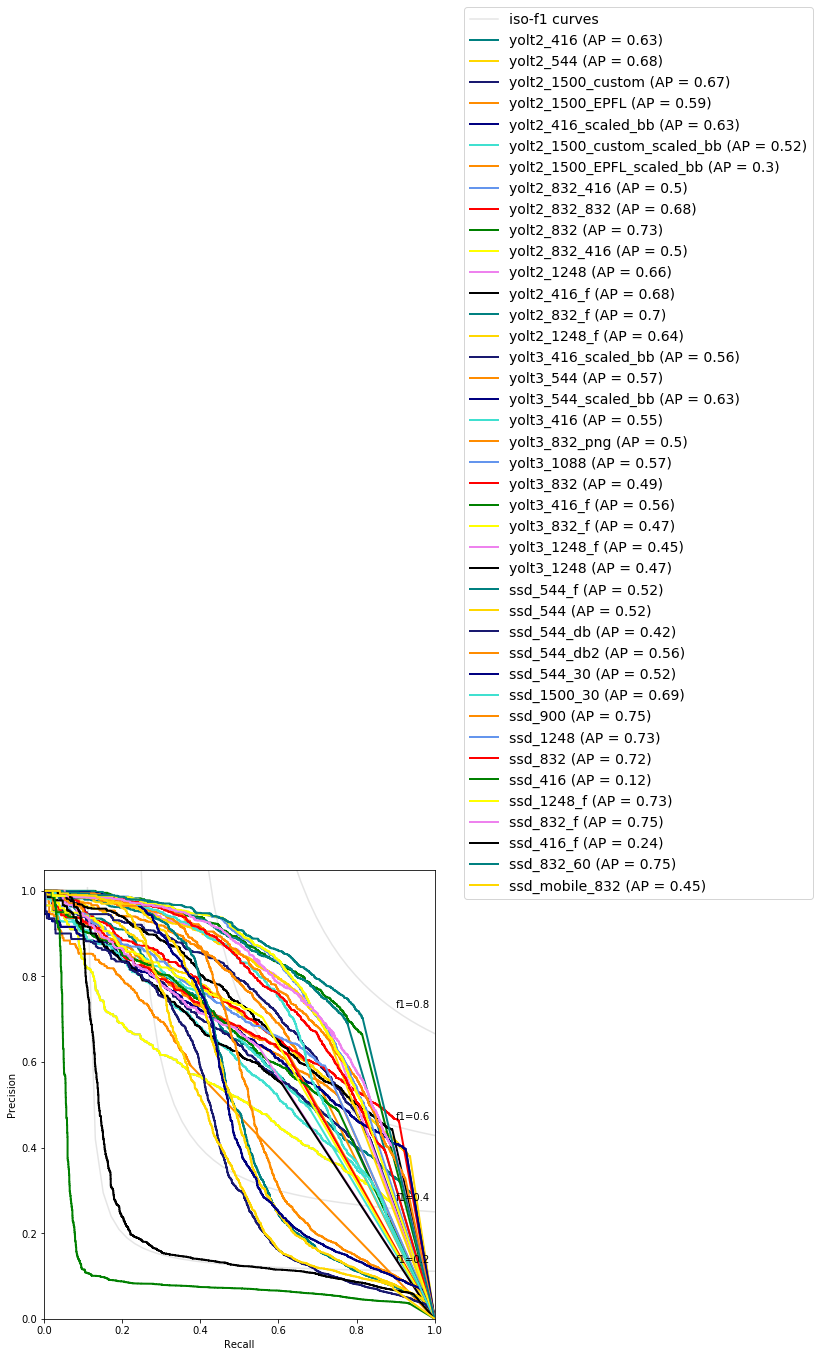

In [88]:
# setup plot details
colors = cycle([ 'teal', 'gold', 'midnightblue', 'darkorange','navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'])
#'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

for key_value, color in zip(check_list, colors):
    print(key_value)
    l, = plt.plot(recall[key_value], precision[key_value], color=color, lw=2)
    lines.append(l)
    labels.append(f'{key_value} (AP = {round(ap_dict[key_value], 2)})')

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#  plt.title('Precision-Recall curve to multi-models')
plt.legend(lines, labels, loc='lower left', prop=dict(size=14), borderaxespad = 30)


plt.show()
#filename = '../ApiZoom_SIMRDWN_dataOUT/master/' + "YOLT2_Precision_Recall.png"
#fig.savefig(filename)

In [89]:
check_list = [
                 'yolt2_416',\
                 'yolt2_832',\
                 'yolt2_1248',\
                   ]

yolt2_416
yolt2_832
yolt2_1248


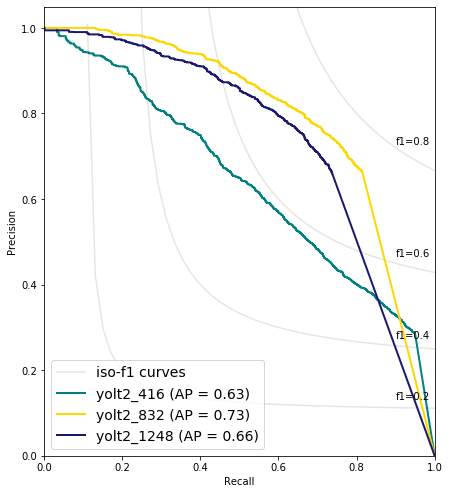

In [90]:
# setup plot details
colors = cycle([ 'teal', 'gold', 'midnightblue', 'darkorange','navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'])
#'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

for key_value, color in zip(check_list, colors):
    print(key_value)
    l, = plt.plot(recall[key_value], precision[key_value], color=color, lw=2)
    lines.append(l)
    labels.append(f'{key_value} (AP = {round(ap_dict[key_value], 2)})')

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#  plt.title('Precision-Recall curve to multi-models')
plt.legend(lines, labels, loc='lower left', prop=dict(size=14) )#, borderaxespad = 30)


plt.show()
#filename = '../ApiZoom_SIMRDWN_dataOUT/master/' + "YOLT2_Precision_Recall.png"
#fig.savefig(filename)

In [91]:
check_list = [
                    'yolt3_416',\
                     'yolt3_832',\
                    'yolt3_1248',\
                ]

yolt3_416
yolt3_832
yolt3_1248


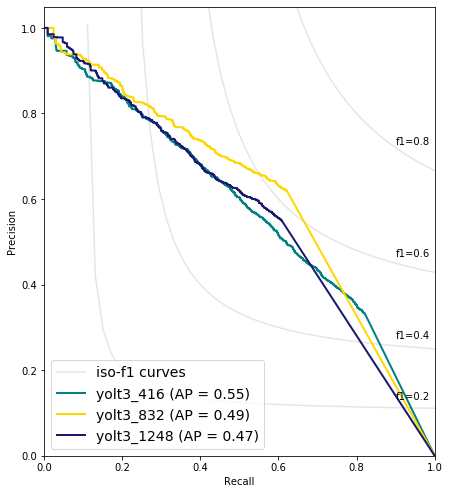

In [92]:
# setup plot details
colors = cycle([ 'teal', 'gold', 'midnightblue', 'darkorange','navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'])
#'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

for key_value, color in zip(check_list, colors):
    print(key_value)
    l, = plt.plot(recall[key_value], precision[key_value], color=color, lw=2)
    lines.append(l)
    labels.append(f'{key_value} (AP = {round(ap_dict[key_value], 2)})')

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#  plt.title('Precision-Recall curve to multi-models')
plt.legend(lines, labels, loc='lower left', prop=dict(size=14) )#, borderaxespad = 30)


plt.show()
#filename = '../ApiZoom_SIMRDWN_dataOUT/master/' + "YOLT2_Precision_Recall.png"
#fig.savefig(filename)

In [93]:
check_list = [
                'ssd_mobile_832',\
                'ssd_832',\
                'ssd_832_60',\
                'ssd_1248',\
                'ssd_416',\
#                 'ssd_832_f',\
#                 'ssd_1248_f',\
#                 'ssd_416_f',\
                   ]


ssd_mobile_832
ssd_832
ssd_832_60
ssd_1248
ssd_416


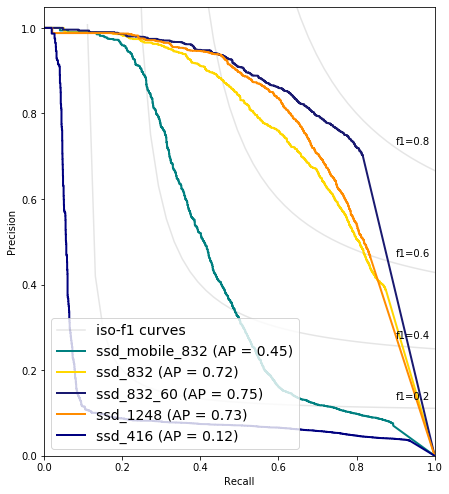

In [94]:
# setup plot details
colors = cycle([ 'teal', 'gold', 'midnightblue', 'darkorange','navy', 'turquoise', 'darkorange', 'corn.flowerblue', 'red', 'green', 'yellow', 'violet', 'black'])
#'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

for key_value, color in zip(check_list, colors):
    print(key_value)
    l, = plt.plot(recall[key_value], precision[key_value], color=color, lw=2)
    lines.append(l)
    labels.append(f'{key_value} (AP = {round(ap_dict[key_value], 2)})')

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#  plt.title('Precision-Recall curve to multi-models')
plt.legend(lines, labels, loc='lower left', prop=dict(size=14)) #, borderaxespad = 30)


plt.show()
#filename = '../ApiZoom_SIMRDWN_dataOUT/master/' + "YOLT2_Precision_Recall.png"
#fig.savefig(filename)

In [95]:
check_list = [

                 'yolt2_1248',\
                 'yolt3_1248',\
                'ssd_1248',\
                   ]


yolt2_1248
yolt3_1248
ssd_1248


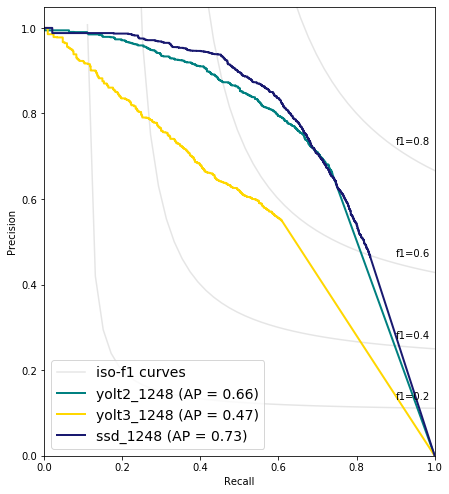

In [96]:
# setup plot details
colors = cycle([ 'teal', 'gold', 'midnightblue', 'darkorange','navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'])
#'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

for key_value, color in zip(check_list, colors):
    print(key_value)
    l, = plt.plot(recall[key_value], precision[key_value], color=color, lw=2)
    lines.append(l)
    labels.append(f'{key_value} (AP = {round(ap_dict[key_value], 2)})')

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#  plt.title('Precision-Recall curve to multi-models')
plt.legend(lines, labels, loc='lower left', prop=dict(size=14))


plt.show()
#filename = '../ApiZoom_SIMRDWN_dataOUT/master/' + "YOLT2_Precision_Recall.png"
#fig.savefig(filename)

In [63]:
df_inference_time = pd.read_csv(file_path_out + 'MasterThesis_inference_time.csv')
df_inference_time

model  split_images  inference     refine       total
0          yolt2_832     43.856928  22.276506   1.042795   70.588052
1         yolt2_1248     45.451534  17.386918   0.951772   66.401649
2          yolt2_416     49.868667  52.640507   2.886337  120.939255
3           ssd_1248     44.706718  24.673677   1.496032   74.902769
4            ssd_832     43.215044  30.632322  82.819533  163.834053
5            ssd_416     46.212493  69.809636  41.022018  353.855935
6          yolt3_416     49.194998  95.636481   2.517704  168.409387
7          yolt3_832     43.065323  81.335392   2.113727  139.724374
8         yolt3_1248     44.655873  20.357859   1.102681   71.150953
9               Mean     45.580842  46.083255  15.105844  136.645158
10    Mean 416 x 416     48.425386  72.695541  15.475353  214.401526
11    Mean 832 x 832     43.379099  44.748073  28.658685  124.715493
12  Mean 1248 x 1248     44.938042  20.806151   1.183495   70.818457
13        Mean YOLT2     46.392376  30.767977   1.626968   85.976319
14        Mean YOLT3     45.638731  65.776577   1.911371  126.428238
15          Mean SSD     44.711419  41.705211  41.779194  197.530919

In [64]:
df_results

TP     FP    FN  AP_IoU=.50                           ID
0   2621   6525   139    0.632614                    yolt2_416
1   2587   4273   173    0.682022                    yolt2_544
2   2326   3457   434    0.668721            yolt2_1500_custom
3   1890   1365   870    0.588039              yolt2_1500_EPFL
4   2555   3889   205    0.631107          yolt2_416_scaled_bb
5   1883   1981   877    0.521334  yolt2_1500_custom_scaled_bb
6   1035    713  1725    0.296876    yolt2_1500_EPFL_scaled_bb
7   2456   6558   304    0.500349                yolt2_832_416
8   2509   2952   251    0.676734                yolt2_832_832
9   2248   1138   512    0.732647                    yolt2_832
10  2037   1054   723    0.658181                   yolt2_1248
11  2461   3107   299    0.675167                  yolt2_416_f
12  2147    981   613    0.704946                  yolt2_832_f
13  1985    943   775    0.644098                 yolt2_1248_f
14  2186   3087   574    0.563448          yolt3_416_scaled_bb
15  2072   1885   688    0.570547                    yolt3_544
16  2555   3889   205    0.631107          yolt3_544_scaled_bb
17  2269   4589   491    0.548628                    yolt3_416
18  1732   1082  1028    0.498485                yolt3_832_png
19  1985   1369   775    0.570563                   yolt3_1088
20  1715   1053  1045    0.494614                    yolt3_832
21  1682   1385  1078    0.465378                   yolt3_1248
22  2082   2212   678    0.560912                  yolt3_416_f
23  1543    646  1217    0.469836                  yolt3_832_f
24  1521    879  1239    0.447067                 yolt3_1248_f
25  2721  82521    39    0.524048                    ssd_544_f
26  2695  75723    65    0.516833                      ssd_544
27  2713  95331    47    0.424014                   ssd_544_db
28  2677  38776    83    0.562739                  ssd_544_db2
29  2670  37862    90    0.522011                   ssd_544_30
30  2438   8259   322    0.690929                  ssd_1500_30
31  2553   5237   207    0.749781                      ssd_900
32  2306   2669   454    0.728867                     ssd_1248
33  2416   3828   344    0.719825                      ssd_832
34  2253    966   507    0.745612                   ssd_832_60
35  2586  71542   174    0.117221                      ssd_416
36  2283   2593   477    0.725241                   ssd_1248_f
37  2478   3787   282    0.751280                    ssd_832_f
38  2610  42589   150    0.236256                    ssd_416_f

In [65]:
df_final = pd.merge(df_results, df_inference_time, left_on='ID',right_on='model', how='inner')
df_final = df_final.round({'AP_IoU=.50': 2, 'split_images': 2, 'inference': 2, 'refine': 2, 'total': 2})
df_final

TP     FP    FN  AP_IoU=.50          ID       model  split_images  \
0  2621   6525   139        0.63   yolt2_416   yolt2_416         49.87   
1  2248   1138   512        0.73   yolt2_832   yolt2_832         43.86   
2  2037   1054   723        0.66  yolt2_1248  yolt2_1248         45.45   
3  2269   4589   491        0.55   yolt3_416   yolt3_416         49.19   
4  1715   1053  1045        0.49   yolt3_832   yolt3_832         43.07   
5  1682   1385  1078        0.47  yolt3_1248  yolt3_1248         44.66   
6  2306   2669   454        0.73    ssd_1248    ssd_1248         44.71   
7  2416   3828   344        0.72     ssd_832     ssd_832         43.22   
8  2586  71542   174        0.12     ssd_416     ssd_416         46.21   

   inference  refine   total  
0      52.64    2.89  120.94  
1      22.28    1.04   70.59  
2      17.39    0.95   66.40  
3      95.64    2.52  168.41  
4      81.34    2.11  139.72  
5      20.36    1.10   71.15  
6      24.67    1.50   74.90  
7      30.63   82.82  163.83  
8      69.81   41.02  353.86

In [66]:
df_final.to_csv(file_path_out + 'df_final.csv', encoding='utf-8', index = False)

# Calculate by image precision recall

In [97]:
check_list_img = ['ssd_832_60']

In [98]:
precision_img = dict()
recall_img = dict()
ap_dict_img = dict()
dict_all_img = dict()
df_results_img = pd.DataFrame(columns=['TP', 'FP', 'FN', 'AP_IoU=.50'])

for key, value in dict_pred_df.items():  
    if key in check_list_img:
    # for precision recall curve we need all values without a threshhold
        print('### ' + key + ' ###')
        print('evaluated with: test_gt')

        
        for img in dict_wh_resized.keys():
            print(img)
            print('length gt: ', len(test_gt[test_gt['filename'] == img]))
            print('length prediction: ', len(value[value['Image_Root'] == img]))
            df_gt, df_pred, TP, FP, FN, ap, mrec, mprec, rec, prec = main2.get_results(value[value['Image_Root'] == img], test_gt[test_gt['filename'] == img], 0.5, 0)
            df_pred0['match'] = df_pred0['gt_index'].apply(lambda x: 0 if x == None else 1)
            df_all = pd.merge(test_gt, df_pred0, left_index = True, right_on='gt_index', how = 'outer')
            df_all.fillna(0, inplace = True) 
            #print('length df_pred0: ', len(df_pred0))
            #print('length df_all: ', len(df_all))
            dict_all_img[img] = df_all
            precision_img[img], recall_img[img] = mprec, mrec
            ap_dict_img[img] = ap
            df_results_img = df_results_img.append({'ID': key, 'TP': TP, 'FP' : FP, 'FN': FN, 'average precision': ap}, ignore_index=True)
            

### ssd_832_60 ###
evaluated with: test_gt
test_set_58e7c5e3579e52085efb48f4_overlay_resized.jpg
length gt:  2
length prediction:  3
minimal overlap: 0.5
threshhold: 0
nd:  3
fp -1:  1
tp -1:  2
100.00% = 0 AP 
mAP = 100.00%

# Number of ground-truth objects per class
0: 2

TP: 2, FP: 1
FN: 0

 Precision: 0.6666666666666666
 Recall :1.0
 F1-score: 0.8

5
-------------------------------------------------------
test_set_599ad189579e52a0e6c05e58_overlay_resized.jpg
length gt:  541
length prediction:  302
minimal overlap: 0.5
threshhold: 0


/Users/fight/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/_ApiZoom_SIMRDWN/ApiZoom_SIMRDWN_notebooks/mAP_daniel/main2.py:520: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gt['overlap'], df_gt['used'], df_gt['pred_index'] = None, None, None
/Users/fight/Library/Mobile Documents/com~apple~CloudDocs/Masterarbeit/_ApiZoom_SIMRDWN/ApiZoom_SIMRDWN_notebooks/venv_simrdwn/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


nd:  302
fp -1:  68
tp -1:  234
38.86% = 0 AP 
mAP = 38.86%

# Number of ground-truth objects per class
0: 541

TP: 234, FP: 68
FN: 307

 Precision: 0.7748344370860927
 Recall :0.43253234750462105
 F1-score: 0.5551601423487544

304
-------------------------------------------------------
test_set_58ea4f69579e520dd055b3db_overlay_resized.jpg
length gt:  3
length prediction:  16
minimal overlap: 0.5
threshhold: 0
nd:  16
fp -1:  13
tp -1:  3
75.76% = 0 AP 
mAP = 75.76%

# Number of ground-truth objects per class
0: 3

TP: 3, FP: 13
FN: 0

 Precision: 0.1875
 Recall :1.0
 F1-score: 0.3157894736842105

18
-------------------------------------------------------
test_set_598a0f0f579e528819ade1f0_overlay_resized.jpg
length gt:  53
length prediction:  119
minimal overlap: 0.5
threshhold: 0
nd:  119
fp -1:  72
tp -1:  47
76.38% = 0 AP 
mAP = 76.38%

# Number of ground-truth objects per class
0: 53

TP: 47, FP: 72
FN: 6

 Precision: 0.3949579831932773
 Recall :0.8867924528301887
 F1-score: 0.5465

test_set_599ad824579e52a0e6c05e5b_overlay_resized.jpg
test_set_599ad189579e52a0e6c05e58_overlay_resized.jpg
test_set_5984d804579e529fdea8af0f_overlay_resized.jpg
test_set_59b0160ea07d5630fdf12ae1_overlay_resized.jpg
test_set_58ea4f69579e520dd055b3db_overlay_resized.jpg
test_set_598a0f0f579e528819ade1f0_overlay_resized.jpg
test_set_59989236a07d5632dfefa440_overlay_resized.jpg
test_set_5991a401579e52a0e6c05e48_overlay_resized.jpg
test_set_59b3e7bfa07d5663dec62543_overlay_resized.jpg
test_set_5903312b579e52581ddedea8_overlay_resized.jpg
test_set_5984dc46579e529fdea8af12_overlay_resized.jpg
test_set_59993d62a07d5632dfefa445_overlay_resized.jpg
test_set_59496f73579e529fdea8af00_overlay_resized.jpg
test_set_59a57c0aa07d565d45b82dc1_overlay_resized.jpg
test_set_59cb57f8a07d562888f854f5_overlay_resized.jpg
test_set_599d4db0579e52a0e6c05e6a_overlay_resized.jpg
test_set_599ab9d9579e52a0e6c05e56_overlay_resized.jpg
test_set_599a8abb579e52a0e6c05e4c_overlay_resized.jpg
test_set_59450ede579e529fdea

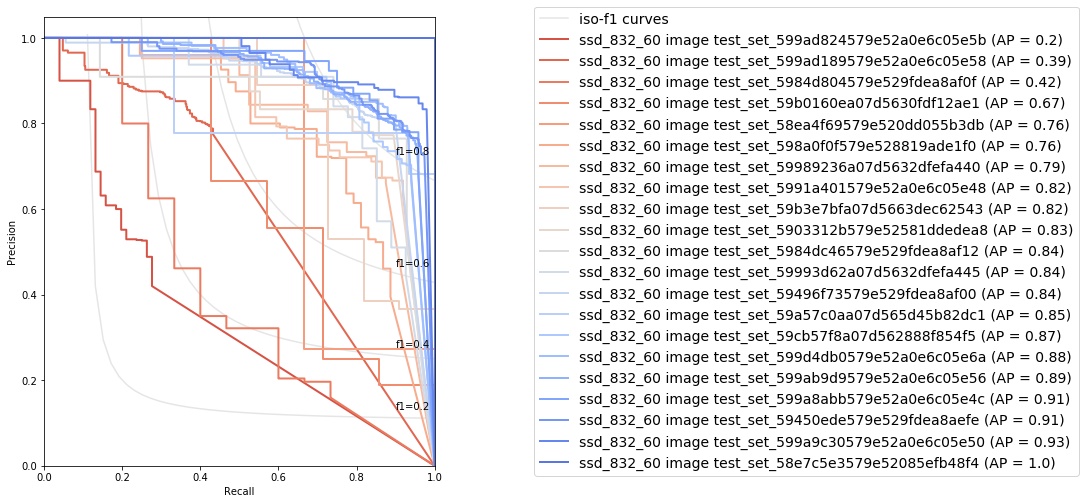

In [99]:
# setup plot details
colors = cycle([ 'teal', 'gold', 'midnightblue', 'darkorange'])
#'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'violet', 'black'
n = len(ap_dict_img)
colors = plt.cm.coolwarm(np.linspace(0.9,0.1,n))

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

ap_dict_img = {k: v for k, v in sorted(ap_dict_img.items(), key=lambda item: item[1])}

for key_value, color in zip(ap_dict_img.keys(), colors):
    print(key_value)
    l, = plt.plot(recall_img[key_value], precision_img[key_value], color=color, lw=2)
    lines.append(l)
    labels.append(f'{check_list_img[0]} image {key_value[:-20]} (AP = {round(ap_dict_img[key_value], 2)})')

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#  plt.title('Precision-Recall curve to multi-models')
plt.legend(lines, labels, loc='center left', prop=dict(size=14), borderaxespad = 35)


plt.show()
#filename = '../ApiZoom_SIMRDWN_dataOUT/master/' + "YOLT2_Precision_Recall.png"
#fig.savefig(filename)

# EPFL bounding boxes distributions

In [72]:
df_EPFL['x_width'] = df_EPFL['x2'] - df_EPFL['x1'] 
df_EPFL['y_height'] = df_EPFL['y2'] - df_EPFL['y1'] 
df_EPFL['bb_diag_cut'] = np.sqrt( df_EPFL['x_width'] **2 +  df_EPFL['y_height'] **2)

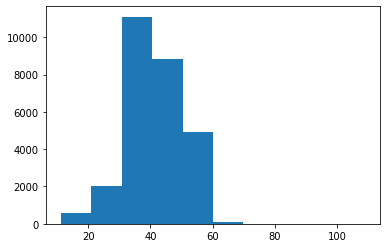

290

In [73]:
plt.hist(df_EPFL['bb_diag_cut'], bins=10)
plt.show()
len(df_EPFL['filename'].unique())

In [74]:
df_EPFL_train_gt = df_EPFL[df_EPFL['filename'].str.contains('test', regex=True)==False]
df_EPFL_test_gt = df_EPFL[df_EPFL['filename'].str.contains('test', regex=True)==True]
#df_EPFL_val_gt = df_EPFL[df_EPFL['filename'].str.contains('validation', regex=True)==True]
print('train: ' + str(len(df_EPFL_train_gt)) + ' test: ' + str(len(df_EPFL_test_gt))) #+ ' val: ' + str(len(df_EPFL_val_gt)) 
print('total: ' + str(len(df_EPFL_train_gt)  + len(df_EPFL_test_gt))) #+ len(df_EPFL_val_gt)

train: 24648 test: 2849
total: 27497


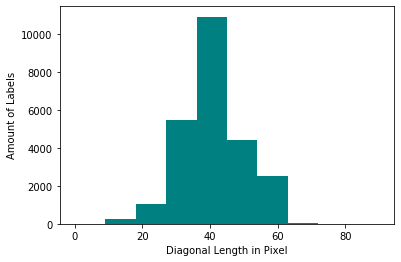

number of images: 269
average: 40.66841372856279


In [75]:
plt.hist(df_EPFL_train_gt['bb_diag_cut'], bins=10, range= (0, 90), color = 'teal')
plt.xlabel('Diagonal Length in Pixel')
plt.ylabel('Amount of Labels')
plt.show()
print('number of images: ' + str(len(df_EPFL_train_gt['filename'].unique())))
print('average: ' + str(df_EPFL_train_gt['bb_diag_cut'].mean()))

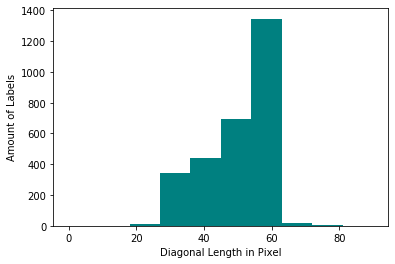

number of images: 21
average: 49.355199234200775


In [76]:
plt.hist(df_EPFL_test_gt['bb_diag_cut'], bins=10, range= (0, 90), color = 'teal')
plt.xlabel('Diagonal Length in Pixel')
plt.ylabel('Amount of Labels')
plt.show()
len(df_EPFL_test_gt['filename'].unique())
print('number of images: ' + str(len(df_EPFL_test_gt['filename'].unique())))
print('average: ' + str(df_EPFL_test_gt['bb_diag_cut'].mean()))

In [77]:
df_EPFL_test_gt.groupby(['filename']).mean()

x1           y1  \
filename                                                                 
test_set_58e7c5e3579e52085efb48f4_32px_0.jpg  1350.000000  1383.000000   
test_set_58ea4f69579e520dd055b3db_32px_0.jpg  3086.000000  2245.666667   
test_set_5903312b579e52581ddedea8_32px_0.jpg  4250.543478  3434.521739   
test_set_59450ede579e529fdea8aefe_32px_0.jpg  5055.585434  2900.896359   
test_set_59496f73579e529fdea8af00_32px_0.jpg  3762.001511  2765.430514   
test_set_5984d804579e529fdea8af0f_32px_0.jpg  1529.266667   744.933333   
test_set_5984dc46579e529fdea8af12_32px_0.jpg  1890.000000  1503.428571   
test_set_598a0f0f579e528819ade1f0_32px_0.jpg  3354.573770  2679.557377   
test_set_5991a401579e52a0e6c05e48_32px_0.jpg  4067.552632  2063.631579   
test_set_59989236a07d5632dfefa440_32px_0.jpg  1771.121951  1323.121951   
test_set_59993d62a07d5632dfefa445_32px_0.jpg  1715.370370  1006.666667   
test_set_599a8abb579e52a0e6c05e4c_32px_0.jpg  2857.734694  1587.469388   
test_set_599a9c30579e52a0e6c05e50_32px_0.jpg  3434.510204  1958.275510   
test_set_599ab9d9579e52a0e6c05e56_32px_0.jpg  2074.238329  1522.857494   
test_set_599ad189579e52a0e6c05e58_32px_0.jpg  3830.660746  1730.282416   
test_set_599ad824579e52a0e6c05e5b_32px_0.jpg  5626.139241  2966.746835   
test_set_599d4db0579e52a0e6c05e6a_32px_0.jpg  2203.026515  1625.439394   
test_set_59a57c0aa07d565d45b82dc1_32px_0.jpg  3059.937500  1639.187500   
test_set_59b0160ea07d5630fdf12ae1_32px_0.jpg  2605.428571   763.571429   
test_set_59b3e7bfa07d5663dec62543_32px_0.jpg  2694.454545  3669.363636   
test_set_59cb57f8a07d562888f854f5_32px_0.jpg  4605.842697  2000.483146   

                                                       x2           y2  \
filename                                                                 
test_set_58e7c5e3579e52085efb48f4_32px_0.jpg  1383.500000  1416.500000   
test_set_58ea4f69579e520dd055b3db_32px_0.jpg  3126.000000  2285.666667   
test_set_5903312b579e52581ddedea8_32px_0.jpg  4285.217391  3470.304348   
test_set_59450ede579e529fdea8aefe_32px_0.jpg  5089.563025  2935.789916   
test_set_59496f73579e529fdea8af00_32px_0.jpg  3802.001511  2805.430514   
test_set_5984d804579e529fdea8af0f_32px_0.jpg  1569.266667   784.933333   
test_set_5984dc46579e529fdea8af12_32px_0.jpg  1930.000000  1543.428571   
test_set_598a0f0f579e528819ade1f0_32px_0.jpg  3386.049180  2711.934426   
test_set_5991a401579e52a0e6c05e48_32px_0.jpg  4100.263158  2097.210526   
test_set_59989236a07d5632dfefa440_32px_0.jpg  1812.463415  1366.195122   
test_set_59993d62a07d5632dfefa445_32px_0.jpg  1758.555556  1051.037037   
test_set_599a8abb579e52a0e6c05e4c_32px_0.jpg  2897.734694  1627.469388   
test_set_599a9c30579e52a0e6c05e50_32px_0.jpg  3467.551020  1992.122449   
test_set_599ab9d9579e52a0e6c05e56_32px_0.jpg  2114.238329  1562.857494   
test_set_599ad189579e52a0e6c05e58_32px_0.jpg  3856.209591  1757.095915   
test_set_599ad824579e52a0e6c05e5b_32px_0.jpg  5651.658228  2992.746835   
test_set_599d4db0579e52a0e6c05e6a_32px_0.jpg  2237.814394  1661.666667   
test_set_59a57c0aa07d565d45b82dc1_32px_0.jpg  3095.250000  1674.375000   
test_set_59b0160ea07d5630fdf12ae1_32px_0.jpg  2623.142857   782.142857   
test_set_59b3e7bfa07d5663dec62543_32px_0.jpg  2727.727273  3704.636364   
test_set_59cb57f8a07d562888f854f5_32px_0.jpg  4636.539326  2032.573034   

                                                x_width   y_height  \
filename                                                             
test_set_58e7c5e3579e52085efb48f4_32px_0.jpg  33.500000  33.500000   
test_set_58ea4f69579e520dd055b3db_32px_0.jpg  40.000000  40.000000   
test_set_5903312b579e52581ddedea8_32px_0.jpg  34.673913  35.782609   
test_set_59450ede579e529fdea8aefe_32px_0.jpg  33.977591  34.893557   
test_set_59496f73579e529fdea8af00_32px_0.jpg  40.000000  40.000000   
test_set_5984d804579e529fdea8af0f_32px_0.jpg  40.000000  40.000000   
test_set_5984dc46579e529fdea8af12_32px_0.jpg  40.000000  40.000000   
test_set_598a0f0f57

# Custom bounding boxes distributions

In [78]:
test_gt_bb['x_width'] = test_gt_bb['x2'] - test_gt_bb['x1'] 
test_gt_bb['y_height'] = test_gt_bb['y2'] - test_gt_bb['y1'] 
test_gt_bb['bb_diag_cut'] = np.sqrt( test_gt_bb['x_width'] **2 +  test_gt_bb['y_height'] **2)
test_gt_bb.groupby(['org_img']).mean()   

x_via        y_via  width_via  \
org_img                                                                  
test_set_58e7c5e3579e52085efb48f4  1485.000000  1521.500000  37.500000   
test_set_58ea4f69579e520dd055b3db  2238.000000  1628.666667  29.000000   
test_set_5903312b579e52581ddedea8  2790.657895  2204.815789  22.236842   
test_set_59450ede579e529fdea8aefe  3778.798246  2170.631579  25.517544   
test_set_59496f73579e529fdea8af00  4464.186846  3304.390135  46.617339   
test_set_5984d804579e529fdea8af0f  1915.133333   934.800000  42.733333   
test_set_5984dc46579e529fdea8af12  2883.857143  2293.071429  61.000000   
test_set_598a0f0f579e528819ade1f0  2021.433962  1602.056604  18.169811   
test_set_5991a401579e52a0e6c05e48  3043.378378  1543.027027  24.000000   
test_set_59989236a07d5632dfefa440  2287.625000  1668.125000  51.350000   
test_set_59993d62a07d5632dfefa445  1801.222222  1057.333333  44.962963   
test_set_599a8abb579e52a0e6c05e4c  2559.645833  1438.541667  35.895833   
test_set_599a9c30579e52a0e6c05e50  2721.618557  1553.319588  26.247423   
test_set_599ab9d9579e52a0e6c05e56  1716.877805  1257.289277  31.778055   
test_set_599ad189579e52a0e6c05e58  3281.622921  1445.194085  20.988909   
test_set_599ad824579e52a0e6c05e5b  3659.394737  1943.763158  15.894737   
test_set_599d4db0579e52a0e6c05e6a  1781.489627  1303.738589  28.178423   
test_set_59a57c0aa07d565d45b82dc1  2357.200000  1221.266667  24.266667   
test_set_59b0160ea07d5630fdf12ae1  3257.428571   953.714286  23.428571   
test_set_59b3e7bfa07d5663dec62543  1836.090909  2500.454545  23.272727   
test_set_59cb57f8a07d562888f854f5  3091.385542  1334.144578  20.240964   

                                   height_via  cx  cy   r           x1  \
org_img                                                                  
test_set_58e7c5e3579e52085efb48f4   37.000000 NaN NaN NaN  1128.000000   
test_set_58ea4f69579e520dd055b3db   29.000000 NaN NaN NaN  2182.666667   
test_set_5903312b579e52581ddedea8   22.684211 NaN NaN NaN  3554.526316   
test_set_59450ede579e529fdea8aefe   26.090643 NaN NaN NaN  4157.745614   
test_set_59496f73579e529fdea8af00   46.533632 NaN NaN NaN  2726.934230   
test_set_5984d804579e529fdea8af0f   42.733333 NaN NaN NaN  1289.133333   
test_set_5984dc46579e529fdea8af12   61.071429 NaN NaN NaN  1336.428571   
test_set_598a0f0f579e528819ade1f0   18.528302 NaN NaN NaN  3130.792453   
test_set_5991a401579e52a0e6c05e48   24.621622 NaN NaN NaN  3559.189189   
test_set_59989236a07d5632dfefa440   53.150000 NaN NaN NaN  1242.850000   
test_set_59993d62a07d5632dfefa445   46.370370 NaN NaN NaN  1117.629630   
test_set_599a8abb579e52a0e6c05e4c   35.895833 NaN NaN NaN  2017.541667   
test_set_599a9c30579e52a0e6c05e50   26.876289 NaN NaN NaN  2912.979381   
test_set_599ab9d9579e52a0e6c05e56   31.693267 NaN NaN NaN  1537.334165   
test_set_599ad189579e52a0e6c05e58   22.005545 NaN NaN NaN  4340.872458   
test_set_599ad824579e52a0e6c05e5b   16.065789 NaN NaN NaN  6531.302632   
test_set_599d4db0579e52a0e6c05e6a   29.049793 NaN NaN NaN  1769.091286   
test_set_59a57c0aa07d565d45b82dc1   25.133333 NaN NaN NaN  2712.333333   
test_set_59b0160ea07d5630fdf12ae1   23.714286 NaN NaN NaN  3923.000000   
test_set_59b3e7bfa07d5663dec62543   24.090909 NaN NaN NaN  2197.727273   
test_set_59cb57f8a07d562888f854f5   21.168675 NaN NaN NaN  4255.385542   

                                            x2           y1           y2  \
org_img                                                                    
test_set_58e7c5e3579e52085efb48f4  1156.000000  1155.000000  1183.500000   
test_set_58ea4f69579e520dd055b3db  2211.000000  1588.333333  1616.666667   
test_set_5903312b579e52581ddedea8  3582.789474  2808.236842  2837.105263   
test_set_59450ede579e529fdea8aefe  4185.842105  2388.307018  2417.026316   
test_set_59496f73579e529fdea8af00  2755.424514  2018.491779  2046.926756   
test_set_5984d804579e529fdea8af0f  1317.866667   629.333333   657.933333   
test_set_5984dc46579e529fde

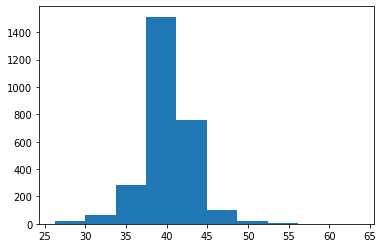

average: 40.24307223256792


In [79]:
plt.hist(test_gt_bb['bb_diag_cut'], bins=10)
plt.show()
len(test_gt_bb['filename'].unique())
print('average: ' + str(test_gt_bb['bb_diag_cut'].mean()))

In [80]:
test_gt_bb.groupby(['filename']).count()

name  x_via  y_via  \
filename                                                                 
test_set_58e7c5e3579e52085efb48f4_overlay_resiz...     2      2      2   
test_set_58ea4f69579e520dd055b3db_overlay_resiz...     3      3      3   
test_set_5903312b579e52581ddedea8_overlay_resiz...    38     38     38   
test_set_59450ede579e529fdea8aefe_overlay_resiz...   342    342    342   
test_set_59496f73579e529fdea8af00_overlay_resiz...   669    669    669   
test_set_5984d804579e529fdea8af0f_overlay_resiz...    15     15     15   
test_set_5984dc46579e529fdea8af12_overlay_resiz...    14     14     14   
test_set_598a0f0f579e528819ade1f0_overlay_resiz...    53     53     53   
test_set_5991a401579e52a0e6c05e48_overlay_resiz...    37     37     37   
test_set_59989236a07d5632dfefa440_overlay_resiz...    40     40     40   
test_set_59993d62a07d5632dfefa445_overlay_resiz...    27     27     27   
test_set_599a8abb579e52a0e6c05e4c_overlay_resiz...    48     48     48   
test_set_599a9c30579e52a0e6c05e50_overlay_resiz...    97     97     97   
test_set_599ab9d9579e52a0e6c05e56_overlay_resiz...   401    401    401   
test_set_599ad189579e52a0e6c05e58_overlay_resiz...   541    541    541   
test_set_599ad824579e52a0e6c05e5b_overlay_resiz...    76     76     76   
test_set_599d4db0579e52a0e6c05e6a_overlay_resiz...   241    241    241   
test_set_59a57c0aa07d565d45b82dc1_overlay_resiz...    15     15     15   
test_set_59b0160ea07d5630fdf12ae1_overlay_resiz...     7      7      7   
test_set_59b3e7bfa07d5663dec62543_overlay_resiz...    11     11     11   
test_set_59cb57f8a07d562888f854f5_overlay_resiz...    83     83     83   

                                                    width_via  height_via  cx  \
filename                                                                        
test_set_58e7c5e3579e52085efb48f4_overlay_resiz...          2           2   0   
test_set_58ea4f69579e520dd055b3db_overlay_resiz...          3           3   0   
test_set_5903312b579e52581ddedea8_overlay_resiz...         38          38   0   
test_set_59450ede579e529fdea8aefe_overlay_resiz...        342         342   0   
test_set_59496f73579e529fdea8af00_overlay_resiz...        669         669   0   
test_set_5984d804579e529fdea8af0f_overlay_resiz...         15          15   0   
test_set_5984dc46579e529fdea8af12_overlay_resiz...         14          14   0   
test_set_598a0f0f579e528819ade1f0_overlay_resiz...         53          53   0   
test_set_5991a401579e52a0e6c05e48_overlay_resiz...         37          37   0   
test_set_59989236a07d5632dfefa440_overlay_resiz...         40          40   0   
test_set_59993d62a07d5632dfefa445_overlay_resiz...         27          27   0   
test_set_599a8abb579e52a0e6c05e4c_overlay_resiz...         48          48   0   
test_set_599a9c30579e52a0e6c05e50_overlay_resiz...         97          97   0   
test_set_599ab9d9579e52a0e6c05e56_overlay_resiz...        401         401   0   
test_set_599ad189579e52a0e6c05e58_overlay_resiz...        541         541   0   
test_set_599ad824579e52a0e6c05e5b_overlay_resiz...         76          76   0   
test_set_599d4db0579e52a0e6c05e6a_overlay_resiz...        241         241   0   
test_set_59a57c0aa07d565d45b82dc1_overlay_resiz...         15          15   0   
test_set_59b0160ea07d5630fdf12ae1_overlay_resiz...          7           7   0   
test_set_59b3e7bfa07d5663dec62543_overlay_resiz...         11          11   0   
test_set_59cb57f8a07d562888f854f5_overlay_resiz...         83          83   0   

                                                    cy  r  org_img   x1   x2  \
filename                                                                       
test_set_58e7c5e3579e52085efb48f4_overlay_resiz...   0  0        2    2    2   
test_set_58ea4f69579e520dd055b3db_overlay_resiz...   0  0        3    3    3   
test_set_5903312b579e52581ddedea8_overlay_resiz...   0  0       38   38   38   
test_set_59450ede579e529fdea8aefe_overlay_resiz...   0  0      342  342  342   
test_